# NEXRAD Radar Reflectivity Visualization with Py-ART and AWS S3
### Overview
This notebook demonstrates how to:
- Access NOAA NEXRAD Level II radar data stored in AWS S3
- Select the radar file closest to a specified date/time
- Download and parse radar reflectivity data using `Py-ART`
- Visualize the radar reflectivity on a map using `Cartopy` and `Matplotlib`

### 📦 Step 1: Import Required Libraries

In [1]:
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.plots import colortables
import numpy as np
import boto3
import tempfile
import os
import re
import pyart
from botocore import UNSIGNED
from botocore.client import Config


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### 🔧 Step 2: Define Utility Functions

In [2]:
def list_files(bucket_name, prefix):
    s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    paginator = s3_client.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket_name, Prefix=prefix)
    files = []
    for page in page_iterator:
        if 'Contents' in page:
            for item in page['Contents']:
                files.append(item['Key'])
    return files

def get_datetime_from_filename(filename):
    match = re.match(r'^{}([0-9]{{8}})_([0-9]{{6}})_V06'.format(station), filename)
    if match:
        date_str = match.group(1)
        time_str = match.group(2)
        datetime_str = date_str + time_str
        return datetime.strptime(datetime_str, '%Y%m%d%H%M%S')
    return None

def find_closest_file(files_times, desired_time):
    min_diff = timedelta.max
    closest_file = None
    for key, file_time in files_times:
        diff = abs(file_time - desired_time)
        if diff < min_diff:
            min_diff = diff
            closest_file = key
    return closest_file

def download_file(bucket_name, key):
    s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    tmp = tempfile.NamedTemporaryFile(delete=False)
    s3_client.download_fileobj(bucket_name, key, tmp)
    tmp.close()
    return tmp.name

### 📅 Step 3: Set Date and Radar Station

In [3]:
date = datetime.utcnow()
# date = datetime(2023, 9, 1, 12, 0, 0)  # Uncomment to manually set a date
station = 'KNQA'

### ☁️ Step 4: Access Radar Files from AWS S3

In [4]:
bucket_name = 'noaa-nexrad-level2'
prefix = f"{date:%Y/%m/%d}/{station}/"
files = list_files(bucket_name, prefix)

### 📂 Step 5: Parse File Timestamps and Find Closest Match

In [5]:
files_times = []
for key in files:
    filename = os.path.basename(key)
    file_dt = get_datetime_from_filename(filename)
    if file_dt:
        files_times.append((key, file_dt))

closest_file_key = find_closest_file(files_times, date)

# If no file found, try previous day
if not closest_file_key:
    date -= timedelta(days=1)
    prefix = f"{date:%Y/%m/%d}/{station}/"
    files = list_files(bucket_name, prefix)
    files_times = [(key, get_datetime_from_filename(os.path.basename(key))) for key in files if get_datetime_from_filename(os.path.basename(key))]
    closest_file_key = find_closest_file(files_times, date)
    if not closest_file_key:
        raise ValueError("No radar files found for the specified date and station.")

### ⬇️ Step 6: Download and Read the Radar File

In [6]:
file_path = download_file(bucket_name, closest_file_key)
radar = pyart.io.read_nexrad_archive(file_path)

### 📈 Step 7: Extract Radar Reflectivity and Geolocation

In [7]:
sweep = 0
ref = radar.get_field(sweep, 'reflectivity')
gate_lats, gate_lons, gate_alts = radar.get_gate_lat_lon_alt(sweep)

### 🗺️ Step 8: Plot Reflectivity with Cartopy

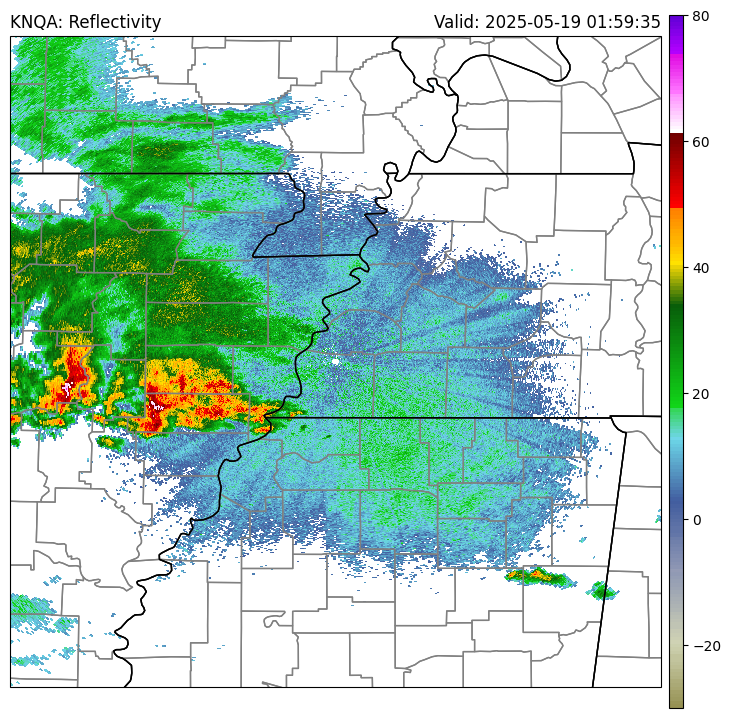

In [8]:
fig, ax = plt.subplots(figsize=(10, 9), subplot_kw=dict(projection=ccrs.PlateCarree()))

cmap = colortables.get_colortable('NWSStormClearReflectivity')
img = ax.pcolormesh(gate_lons, gate_lats, ref, cmap=cmap, vmin=-30, vmax=80)

plt.colorbar(img, ax=ax, orientation='vertical', pad=0.01, aspect=50)

ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_2_counties', '10m', facecolor='none'),
               edgecolor='gray')
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black')

slat = radar.latitude['data'][0]
slon = radar.longitude['data'][0]
ax.set_extent([slon - 2, slon + 2, slat - 2, slat + 2], crs=ccrs.PlateCarree())

start_time = radar.time['units'].split(' ')[-1]
start_dt = datetime.strptime(start_time, '%Y-%m-%dT%H:%M:%SZ')
plt.title(f'{radar.metadata["instrument_name"]}: Reflectivity', loc='left')
plt.title(f'Valid: {start_dt}', loc='right')

plt.show()

### 🧹 Step 9: Clean Up Temporary File

In [9]:
os.remove(file_path)